# Headline Analyzer:
### An analysis of New York Times articles' headlines' use of Covid-19-related terms from December 2019 to December 2022.
#### Jacob Thoma, COMP 4447 Final Project

In [2]:
import os
import json
import time
import requests
import datetime as dt

import tqdm 
import pandas as pd
import numpy as np
import regex as re
import matplotlib.pyplot as plt

# Part 1 - Retrieving Data from The New York Times Archive API

## 1.1 Prepare the Calls to the New York Times Archive API:

### From the Archive API documentation:

The Archive API returns an array of NYT articles for a given month, going back to 1851. Its response fields are the same as the Article Search API. The Archive API is very useful if you want to build your own database of NYT article metadata. You simply pass the API the year and month and it returns a JSON object with all articles for that month. The response size can be large (~20mb).<br>

In [8]:
#Set start & end dates as datetime objects
start = dt.date(2019, 12, 1)
end = dt.date(2022, 12, 31)

#Extract the year & month from the date range as strings
months_in_range = [x.split(' ') for x in pd.date_range(start, end, freq='MS').strftime("%Y %-m").tolist()]

#Show results
print(months_in_range[:5])

[['2019', '12'], ['2020', '1'], ['2020', '2'], ['2020', '3'], ['2020', '4']]


The API takes calls by the **month** in the form of `/{year}/{month}.json`. An example of a full base URL for a call is is:<br><br>
`https://api.nytimes.com/svc/archive/v1/2019/1.json?api-key=yourkey`

Using the daterange in the previous cell, create a list of base URLs to call for each month between December 2019 and December 2022:

In [17]:
#Save the authorization key for the app as a variable
myKey = 'i8AyOeJZ5QgsyEeKXTgHdSwdh9ipd7G2'

#Blank dict to store the calls & associated month
calls = dict()

#For each year, month in the date range:
for d in months_in_range:
    #Set the key to YYYY-MM and the values to the correct URL
    calls[d[0]+'-'+d[1]] = (f'https://api.nytimes.com/svc/archive/v1/{d[0]}/{d[1]}.json?api-key={myKey}')

#Show example urls:
first_three_pairs = {k: calls[k] for k in list(calls)[:3]}

# Print the first three key-value pairs
for key, value in first_three_pairs.items():
    print(key, "->", value)

2019-12 -> https://api.nytimes.com/svc/archive/v1/2019/12.json?api-key=i8AyOeJZ5QgsyEeKXTgHdSwdh9ipd7G2
2020-1 -> https://api.nytimes.com/svc/archive/v1/2020/1.json?api-key=i8AyOeJZ5QgsyEeKXTgHdSwdh9ipd7G2
2020-2 -> https://api.nytimes.com/svc/archive/v1/2020/2.json?api-key=i8AyOeJZ5QgsyEeKXTgHdSwdh9ipd7G2


## 1.2 Make the calls to the API:
Now that we have properly formatted URLs to make the calls, we can go through and call each month's data.<br>

### Important Note:
The NYT API limits calls to a total of 500 per day, and 5 per minute. Therefore - we put a 12 second sleep time between calls to ensure we don't error out the API.

In [21]:
%%skip

#For each URL in calls
for d, u in tqdm.tqdm(calls.items()):
    
    #Get the response as a JSON object
    response = requests.get(u).json()

    #Save the JSON file, annotating the month & year
    with open(f"data/response_{d}.json", 'w') as file:
        json.dump(response, file)

    #Sleep for 12 seconds to ensure we aren't maxing out calls
    time.sleep(12)

100%|██████████| 37/37 [08:56<00:00, 14.51s/it]


# Part 2 - Parsing the Response JSONs into Dataframes
Now that we have all the data we need, we must parse it to extract only the information we need. In this section I explore the data to see what is available and extract the headline and the publication date. 

## 2.1 Explore the Data Structure
Here we will read in a single file to get a general idea of the structure of the response and see where the data we are interested is located.<br>
This search is informed by documentation in the API found here: https://developer.nytimes.com/docs/archive-product/1/types/Article 

In [35]:
#Read in a single file as a JSON object
with open('data/response_2019-12.json', 'r') as file:
    test_data = json.load(file)

#See the first level fields:
print(f'Level 0 Keys: {test_data.keys()}')

#Explore additional fields under "response"
print(f"Response Keys: {test_data['response'].keys()}")

Level 0 Keys: dict_keys(['copyright', 'response'])
Response Keys: dict_keys(['docs', 'meta'])


The data we're interesting in for this analysis is under the "docs" key in the "response" key. The "meta" key contains a dictionary of hits, indicating the number of articles returned in the call. <br> Exploreing the Array under "docs" shows:

In [42]:
#Save the test docs array as a new object
test_docs = test_data['response']['docs']
print(f"{len(test_docs)} articles' data returned in this call.")

#Extract a single article's metadata 
test_article = test_docs[0]
test_article

3985 articles' data returned in this call.


{'abstract': 'President Trump’s aides were delighted that news of his Thanksgiving Day visit to Afghanistan stayed under wraps.',
 'web_url': 'https://www.nytimes.com/2019/11/30/us/politics/white-house-afghanistan-secrecy.html',
 'snippet': 'President Trump’s aides were delighted that news of his Thanksgiving Day visit to Afghanistan stayed under wraps.',
 'lead_paragraph': 'BAGRAM AIR FIELD, Afghanistan — It may be the leakiest White House in history. The news media has unearthed details of President Trump’s calls with foreign leaders, his candid assessments of senior aides and his private daily schedules.',
 'print_section': 'A',
 'print_page': '29',
 'source': 'The New York Times',
 'multimedia': [{'rank': 0,
   'subtype': 'xlarge',
   'caption': None,
   'credit': None,
   'type': 'image',
   'url': 'images/2019/11/30/business/30dc-memo/merlin_165156174_07c045c5-042e-4e14-b010-f816073a27e4-articleLarge.jpg',
   'height': 400,
   'width': 600,
   'subType': 'xlarge',
   'crop_name':

In [44]:
#Look at the headline data
test_article['headline']

{'main': 'A Leak-Prone White House Finally Manages to Keep a Secret',
 'kicker': 'White House Memo',
 'content_kicker': None,
 'print_headline': 'Using Canned Tweets and Tight Lips to Make a Secret Journey',
 'name': None,
 'seo': None,
 'sub': None}

In [45]:
#Extract the publication date
test_article['pub_date']

'2019-12-01T00:15:08+0000'

In [61]:
#Look at keywords
for k in test_article['keywords']:
    print(k)

{'name': 'subject', 'value': 'Afghanistan War (2001- )', 'rank': 1, 'major': 'N'}


In [48]:
#Check out the type of material it was
test_article['type_of_material']

'News'

## 2.2 Parse & extract information from the JSON into a Dataframe
We now know exactly where in the JSON objects the information we want is. In this step, we iterate through the response files and parse out just the data we need and add it into a dataframe.

In [62]:
#Create a dictionary that will be transformed into a dataframe
response_dict = {'publication_date':[],
                 'main_headline':[],
                 'print_headline':[],
                 'material_type':[],
                 'rank_1_kw':[]}

#Get a list of files to be processed, making their full paths along the way
file_paths = ['data/'+x for x in os.listdir('data/')]

#For each file path in the list
for path in tqdm.tqdm(file_paths):

    #Read the file in 
    with open(path, 'r') as file:
        data = json.load(file)
    
    #Extract the docs array - 
    docs = data['response']['docs']

    #For each article in the docs array
    for article in docs:
        #Extract each bit of info & add it to the response dict - 
        response_dict['publication_date'].append(article['pub_date'])
        response_dict['main_headline'].append(article['headline']['main'])
        response_dict['print_headline'].append(article['headline']['print_headline'])
        response_dict['material_type'].append(article['type_of_material'])

        #Keywords are a little different - we are only interested in those with rank 1
        
        #List to store rank 1 keywords
        r1_kws = []
        
        #For each keyword object
        for k in article['keywords']:

            #If the keyword is rank 1
            if k['rank'] == 1:
                r1_kws.append(k['value'])
            
        #Add the keywords list
        response_dict['rank_1_kw'].append(r1_kws) 

#Make the resulting response dict into a dataframe
data = pd.DataFrame(response_dict)

100%|██████████| 37/37 [00:08<00:00,  4.15it/s]


Having a look at the data:

In [63]:
display(data)

,publication_date,main_headline,print_headline,material_type,rank_1_kw
0,2020-04-01T00:00:07+0000,Human Rights Group Says Two U.S. Strikes Kille...,Amnesty International Says U.S. Airstrikes on ...,News,[Civilian Casualties]
1,2020-04-01T00:01:20+0000,‘Never Thought I Would Need It’: Americans Put...,"Newly Needy, And Abashed To Seek Help",News,[Unemployment]
2,2020-04-01T00:43:34+0000,$30 Million in Illegal Drugs Seized From Cross...,$30 Million in Illegal Drugs Seized at Tunnel...,News,[Drug Abuse and Traffic]
3,2020-04-01T01:38:10+0000,"As Furloughs Grow, Kennedy Center Defends Use ...",,News,[Finances]
4,2020-04-01T02:00:03+0000,Historic Town in Veszprém County,,News,[Crossword Puzzles]
...,...,...,...,...,...
162709,2022-06-30T21:00:09+0000,Uber Says Sexual Assaults Down but Traffic Dea...,,News,[Traffic Accidents and Safety]
162710,2022-06-30T21:00:10+0000,Your Friday Briefing: A Major U.S. Climate Ruling,,briefing,[United States International Relations]
162711,2022-06-30T21:05:47+0000,Putin Regains His Swagger,,News,[]
162712,2022-06-30T21:05:48+0000,Alice Elliott Dark Ruins Books by Reading in t...,Alice Elliott Dark,News,[Writing and Writers]


Now that we have the data formatted how we want it, read it as a file so we don't have to go through this all again. 

In [64]:
#Read out as a tab seperated file, incase there are commas in any of the fields
data.to_csv('nyt_article_data_12-2019_to_12_2022.tsv', sep='\t', index=False)

# Part 3 - Data Cleaning & Reformatting
Now that we have the data in the sturcture we need, we need to conduct some cleanup. Some things that need to be done are:
* Convert the publication_date to a proper datetime column and remove records outside the study bounds
* Remove any records that have neither a main or print headline
* Use the material type to weed out records that aren't news realted
* Explore the keywords column for usefulness

## 3.1 Date formatting
In this step I convert the publication date column into proper dates & remove errant records that may have made it through.

In [15]:
#Read the data back in 
data = pd.read_csv('nyt_article_data_12-2019_to_12_2022.tsv', sep='\t')

#Convert the publication date to a datetime column only retaining the date
data.publication_date = pd.to_datetime(data.publication_date).dt.date

#Check if any records outside our time frame:
if len(data.loc[(data.publication_date < dt.date(2019, 12, 1)) | (data.publication_date > dt.date(2022, 12, 31))]) == 0:
    print('No records outside time frame!')


No records outside time frame!


## 3.2 Removing records with no headlines
Here we remove records that have no main or print headline and add a new column that contains the headline to use for the analytic.

In [16]:
#Get the number of records that have no headlines 
no_hl_rec_cnt = len(data.loc[(data.main_headline.isna()) & (data.print_headline.isna())])
print(f'{no_hl_rec_cnt} records with no headline.')

#Drop the records with no headlines
data = data.dropna(subset=['main_headline', 'print_headline'], how='all')

#Check the data to see if there are any nulls in the main headline column - 
data.info()

16 records with no headline.
<class 'pandas.core.frame.DataFrame'>
Int64Index: 162698 entries, 0 to 162713
Data columns (total 5 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   publication_date  162698 non-null  object
 1   main_headline     162698 non-null  object
 2   print_headline    92655 non-null   object
 3   material_type     156987 non-null  object
 4   rank_1_kw         162698 non-null  object
dtypes: object(5)
memory usage: 7.4+ MB


Because there are no longer any Null values in the main headline column, we don't need to add a new column with the correct headline to use for analysis. We can use the "main_headlines" column. 

## 3.3 Filter on material type
Here we explore and filter further on the material type column. 

In [17]:
#See what the values are for material type
data.material_type.value_counts()

News                   115440
Op-Ed                   10719
Review                   7051
Interactive Feature      5231
briefing                 5018
Obituary (Obit)          4054
Video                    3042
Letter                   2101
Slideshow                1459
Quote                     942
Correction                711
Editorial                 558
List                      374
News Analysis             268
Text                        9
Biography                   4
An Appraisal                3
Editors' Note               1
Schedule                    1
Question                    1
Name: material_type, dtype: int64

Now we will narrow down the data further to only include relevant materials - namely:
* News
* Op-ed
* Editorial
* News Analysis

In [18]:
#Make a list of relevant materials
relevent_materials = ['News', 'Op-Ed', 'Editorial', 'News Analysis']
#Reduce data to only the relevent materials
data = data.loc[data.material_type.isin(relevent_materials)]
display(data)

,publication_date,main_headline,print_headline,material_type,rank_1_kw
0,2020-04-01,Human Rights Group Says Two U.S. Strikes Kille...,Amnesty International Says U.S. Airstrikes on ...,News,['Civilian Casualties']
1,2020-04-01,‘Never Thought I Would Need It’: Americans Put...,"Newly Needy, And Abashed To Seek Help",News,['Unemployment']
2,2020-04-01,$30 Million in Illegal Drugs Seized From Cross...,$30 Million in Illegal Drugs Seized at Tunnel...,News,['Drug Abuse and Traffic']
3,2020-04-01,"As Furloughs Grow, Kennedy Center Defends Use ...",NaN,News,['Finances']
4,2020-04-01,Historic Town in Veszprém County,NaN,News,['Crossword Puzzles']
...,...,...,...,...,...
162708,2022-06-30,"As Monkeypox Cases Rise, New York Will Distrib...","As Monkeypox Rises, New York Will Issue 8,000 ...",News,['Vaccination and Immunization']
162709,2022-06-30,Uber Says Sexual Assaults Down but Traffic Dea...,NaN,News,['Traffic Accidents and Safety']
162711,2022-06-30,Putin Regains His Swagger,NaN,News,[]
162712,2022-06-30,Alice Elliott Dark Ruins Books by Reading in t...,Alice Elliott Dark,News,['Writing and Writers']


We've now reduced the data from 162,714 records to 126,985 records. This will help speed up our analysis and ensure only relevant data points are looked at.

## 3.4 Keyword Analysis
Here we now look at the keyword column to see if there is anything that may help us filter the data further.

In [19]:
from collections import Counter

#Create a list to store all the keywords
all_keywords = []

#Iterate through and add the keywords to the list
for k in list(data.rank_1_kw):

    #Ensure it's list type
    k = eval(k)

    #If there are no keywords
    if len(k) < 1:
        all_keywords.append('No Keywords')
    
    #If there is one keyword
    elif len(k) == 1:
        all_keywords.append(k[0])
    
    #If there are multiple keywords
    else:
        for x in k:
            all_keywords.append(x)

kw_counter = Counter(all_keywords)
kw_counter.most_common(25)

[('No Keywords', 9314),
 ('Coronavirus (2019-nCoV)', 5823),
 ('Real Estate and Housing (Residential)', 2413),
 ('United States Politics and Government', 2335),
 ('Presidential Election of 2020', 2197),
 ('Television', 2072),
 ('Russian Invasion of Ukraine (2022)', 1831),
 ('Books and Literature', 1724),
 ('Movies', 1585),
 ('internal-essential', 1507),
 ('Art', 1336),
 ('Cooking and Cookbooks', 1330),
 ('Crossword Puzzles', 1285),
 ('Politics and Government', 1210),
 ('Baseball', 1191),
 ('Weddings and Engagements', 1174),
 ('Trump, Donald J', 1090),
 ('Quarantine (Life and Culture)', 1060),
 ('Theater', 1035),
 ('Biden, Joseph R Jr', 992),
 ('United States Economy', 945),
 ('Global Warming', 846),
 ('Football', 823),
 ('Soccer', 783),
 ('Fashion and Apparel', 751)]

Though there is a distinct 'Coronavirus (2019-nCoV)' keyword, only 5,823 articles are tagged with it. The aim of this study is to look at all headline mentions of covid-19-related words, so further filtering on this column may unintentionally eliminate valid data points. Therefore we will not filter on this. 

## 3.5 Make the final data set
In this last step we eliminate the unnessesary columns and add columns that denote the publication month & year which we will need for the analytic.

In [20]:
#Remove the print_headline & rank_1_kw columns as they are no longer needed
data_reduced = data.drop(columns=['print_headline', 'rank_1_kw'])

#Add a new column that denotes on the month & year of publication
data_reduced['year_month'] = data_reduced.publication_date.apply(lambda x: x.strftime('%B %Y'))

#Exmine the final Dataset
display(data_reduced)

,publication_date,main_headline,material_type,year_month
0,2020-04-01,Human Rights Group Says Two U.S. Strikes Kille...,News,April 2020
1,2020-04-01,‘Never Thought I Would Need It’: Americans Put...,News,April 2020
2,2020-04-01,$30 Million in Illegal Drugs Seized From Cross...,News,April 2020
3,2020-04-01,"As Furloughs Grow, Kennedy Center Defends Use ...",News,April 2020
4,2020-04-01,Historic Town in Veszprém County,News,April 2020
...,...,...,...,...
162708,2022-06-30,"As Monkeypox Cases Rise, New York Will Distrib...",News,June 2022
162709,2022-06-30,Uber Says Sexual Assaults Down but Traffic Dea...,News,June 2022
162711,2022-06-30,Putin Regains His Swagger,News,June 2022
162712,2022-06-30,Alice Elliott Dark Ruins Books by Reading in t...,News,June 2022


In [21]:
#Save out the cleaned data
data_reduced.to_csv('nyt_data_cleaned.tsv', sep='\t', index=False)

# Part 4 - Analysis
In this final section we take the cleaned data and extract the counts of covid-19 related terms in each headline, then we plot the counts to look at how this number has changed over time. 

## 4.1 Extracting covid-19-related terms
In this part we parse through the headlines and get the counts of covid-19 related terms in each headline. The terms we are looking for include:
* Covid or Covid-19
* Coronavirus / virus
* Pandemic / Epidemic
* Vaccine(s) / Vaccination(s)
* Lockdown(s)

In [22]:
#Start by reading the clean data back in
data = pd.read_csv('nyt_data_cleaned.tsv', sep='\t')

#Add a new column that counts the times 'covid' or 'covid-19' is mentioned
data['covid_mentions'] = data.main_headline.apply(lambda x: len(re.findall(r"\b(covid|covid-19)\b", x.lower())))

#Add a new column that counts the times 'pandemic' or 'epidemic' is mentioned
data['Xdemic_mentions'] = data.main_headline.apply(lambda x: len(re.findall(r"\b(epidemic|pandemic)\b", x.lower())))

#Add a new column that counts the times 'coronavirus' or 'virus' is mentioned
data['virus_mentions'] = data.main_headline.apply(lambda x: len(re.findall(r"\b(coronavirus|virus)\b", x.lower())))

#Add a new column that counts the times 'vaccine' or 'vaccination' is mentioned
data['vax_mentions'] = data.main_headline.apply(lambda x: len(re.findall(r"\b(vaccine|vaccines|vaccination|vaccinations)\b", x.lower())))

#Add a new column that counts the times lockdown(s) is mentioned
data['lockdown_mentions'] = data.main_headline.apply(lambda x: len(re.findall(r"\b(lockdown|lockdowns)\b", x.lower())))

#Display the results - 
display(data.loc[data.covid_mentions!=0])

,publication_date,main_headline,material_type,year_month,covid_mentions,Xdemic_mentions,virus_mentions,vax_mentions,lockdown_mentions
31,2020-04-01,Covid-19 Is Twisting 2020 Beyond All Recognition,Op-Ed,April 2020,1,0,0,0,0
42,2020-04-01,"Covid-19 Changed How the World Does Science, T...",News,April 2020,1,0,0,0,0
93,2020-04-01,How Are You Feeling? Surveys Aim to Detect Cov...,News,April 2020,1,0,0,0,0
154,2020-04-02,The Racial Time Bomb in the Covid-19 Crisis,Op-Ed,April 2020,1,0,0,0,0
303,2020-04-02,The Covid-19 Slump Has Arrived,Op-Ed,April 2020,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
125873,2022-06-21,Antiviral drugs for Covid are inequitably pres...,News,June 2022,1,0,0,0,0
125881,2022-06-21,Covid Vaccines Slowly Roll Out for Children Un...,News,June 2022,1,0,0,1,0
126095,2022-06-23,Deborah Birx Says Trump White House Asked Her ...,News,June 2022,1,0,0,0,0
126174,2022-06-23,The White House Covid czar says he’s still opt...,News,June 2022,1,0,0,0,0


In [23]:
#Add an additional column that counts the total number of covid-19-related terms mentioned in the headline

#Cols to sum over
mention_cols = ['covid_mentions', 'Xdemic_mentions', 'virus_mentions', 'vax_mentions', 'lockdown_mentions']
#Calculate the sum
data['total_covid_mentions'] = data[mention_cols].sum(axis=1)

#Sort & display the data by total mentions
display(data.sort_values(by='total_covid_mentions', ascending=False))

,publication_date,main_headline,material_type,year_month,covid_mentions,Xdemic_mentions,virus_mentions,vax_mentions,lockdown_mentions,total_covid_mentions
88596,2020-10-22,Trump in North Carolina: ‘All you hear is Covi...,News,October 2020,5,0,0,0,0,5
88576,2020-10-22,Trump in North Carolina: ‘All you hear is Covi...,News,October 2020,5,0,0,0,0,5
88605,2020-10-22,Trump in North Carolina: ‘All you hear is Covi...,News,October 2020,5,0,0,0,0,5
100630,2020-06-07,‘Pandemic Within a Pandemic’: Coronavirus and ...,News,June 2020,0,2,1,0,0,3
59970,2020-12-15,The Virus Trains: How Lockdown Chaos Spread Co...,News,December 2020,1,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...
44169,2022-03-03,Nilüfer Yanya’s Music Is a Family Affair,News,March 2022,0,0,0,0,0,0
44168,2022-03-03,Galaxy,News,March 2022,0,0,0,0,0,0
44167,2022-03-03,Which Cities Are Best for Walking Your Dog?,News,March 2022,0,0,0,0,0,0
44166,2022-03-03,International pressure is forcing Russian olig...,News,March 2022,0,0,0,0,0,0


Uh oh! Looks like we have some duplicates! Let's remove those now along with any records that have 0 total covid mentions:

In [24]:
#Remove duplicate rows:
data = data.drop_duplicates() #This only drops 40 rows

#Get only the records that have > 0 covid mentions
data = data.loc[data.total_covid_mentions>0].reset_index(drop=True)

#Display the results
display(data.sort_values(by='total_covid_mentions', ascending=False))

,publication_date,main_headline,material_type,year_month,covid_mentions,Xdemic_mentions,virus_mentions,vax_mentions,lockdown_mentions,total_covid_mentions
9196,2020-10-22,Trump in North Carolina: ‘All you hear is Covi...,News,October 2020,5,0,0,0,0,5
11254,2021-03-19,Europe Lifts Vaccine Suspension as Virus Surge...,News,March 2021,0,0,1,1,1,3
2157,2022-04-26,The new White House Covid czar says avoiding a...,News,April 2022,1,1,1,0,0,3
10509,2021-02-05,Israel’s Vaccination Results Point a Way Out o...,News,February 2021,0,1,1,1,0,3
8209,2021-04-15,Can the Covid Vaccine Protect Me Against Virus...,News,April 2021,1,0,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...
4149,2020-02-27,C.D.C. Confirms First Possible Community Trans...,News,February 2020,0,0,1,0,0,1
4150,2020-02-27,Trump Has a Problem as the Coronavirus Threate...,News,February 2020,0,0,1,0,0,1
4151,2020-02-27,"Trump’s Coronavirus Strategy: ‘Stay Clean,’ Wa...",News,February 2020,0,0,1,0,0,1
4152,2020-02-27,"As Coronavirus Slams Small Business, a Noodle ...",News,February 2020,0,0,1,0,0,1


Now we have what we need to make some visualizations! I think it's worth noting that in a 37 month span **12,024** articles had COVID-19 related terms in the headline. 

## 4.2 Visualizing use of Covid-19 related terms over time
In this section we create plots to show the total number of articles that mentioned covid-19-related terms as well as the number of times those terms were mentioned in the study period.

First, we will plot the mentions by category over time:

In [25]:
#Ensure the date is a datetime object
data.publication_date = pd.to_datetime(data.publication_date)

#Grouping by the date and adding the sums accross all mention categories
mentions_by_day = data.groupby('publication_date', as_index=False).sum()

#Join against a datafram with all the dates (articles mentioning covid weren't published everyday)
daily_mentions = pd.DataFrame(pd.date_range(dt.date(2019, 12, 1), dt.date(2022, 12, 31))).set_index(0).join(mentions_by_day.set_index('publication_date'), how='outer')

#Fill the null values with 0
daily_mentions.fillna(0, inplace=True)

#Show the daily mentions data
display(daily_mentions)

,covid_mentions,Xdemic_mentions,virus_mentions,vax_mentions,lockdown_mentions,total_covid_mentions
2019-12-01,0.0,1.0,0.0,0.0,0.0,1.0
2019-12-02,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-03,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-04,0.0,0.0,0.0,0.0,0.0,0.0
2019-12-05,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2022-12-27,1.0,0.0,0.0,0.0,0.0,1.0
2022-12-28,4.0,1.0,0.0,1.0,0.0,6.0
2022-12-29,2.0,0.0,0.0,0.0,0.0,2.0
2022-12-30,0.0,0.0,0.0,0.0,0.0,0.0


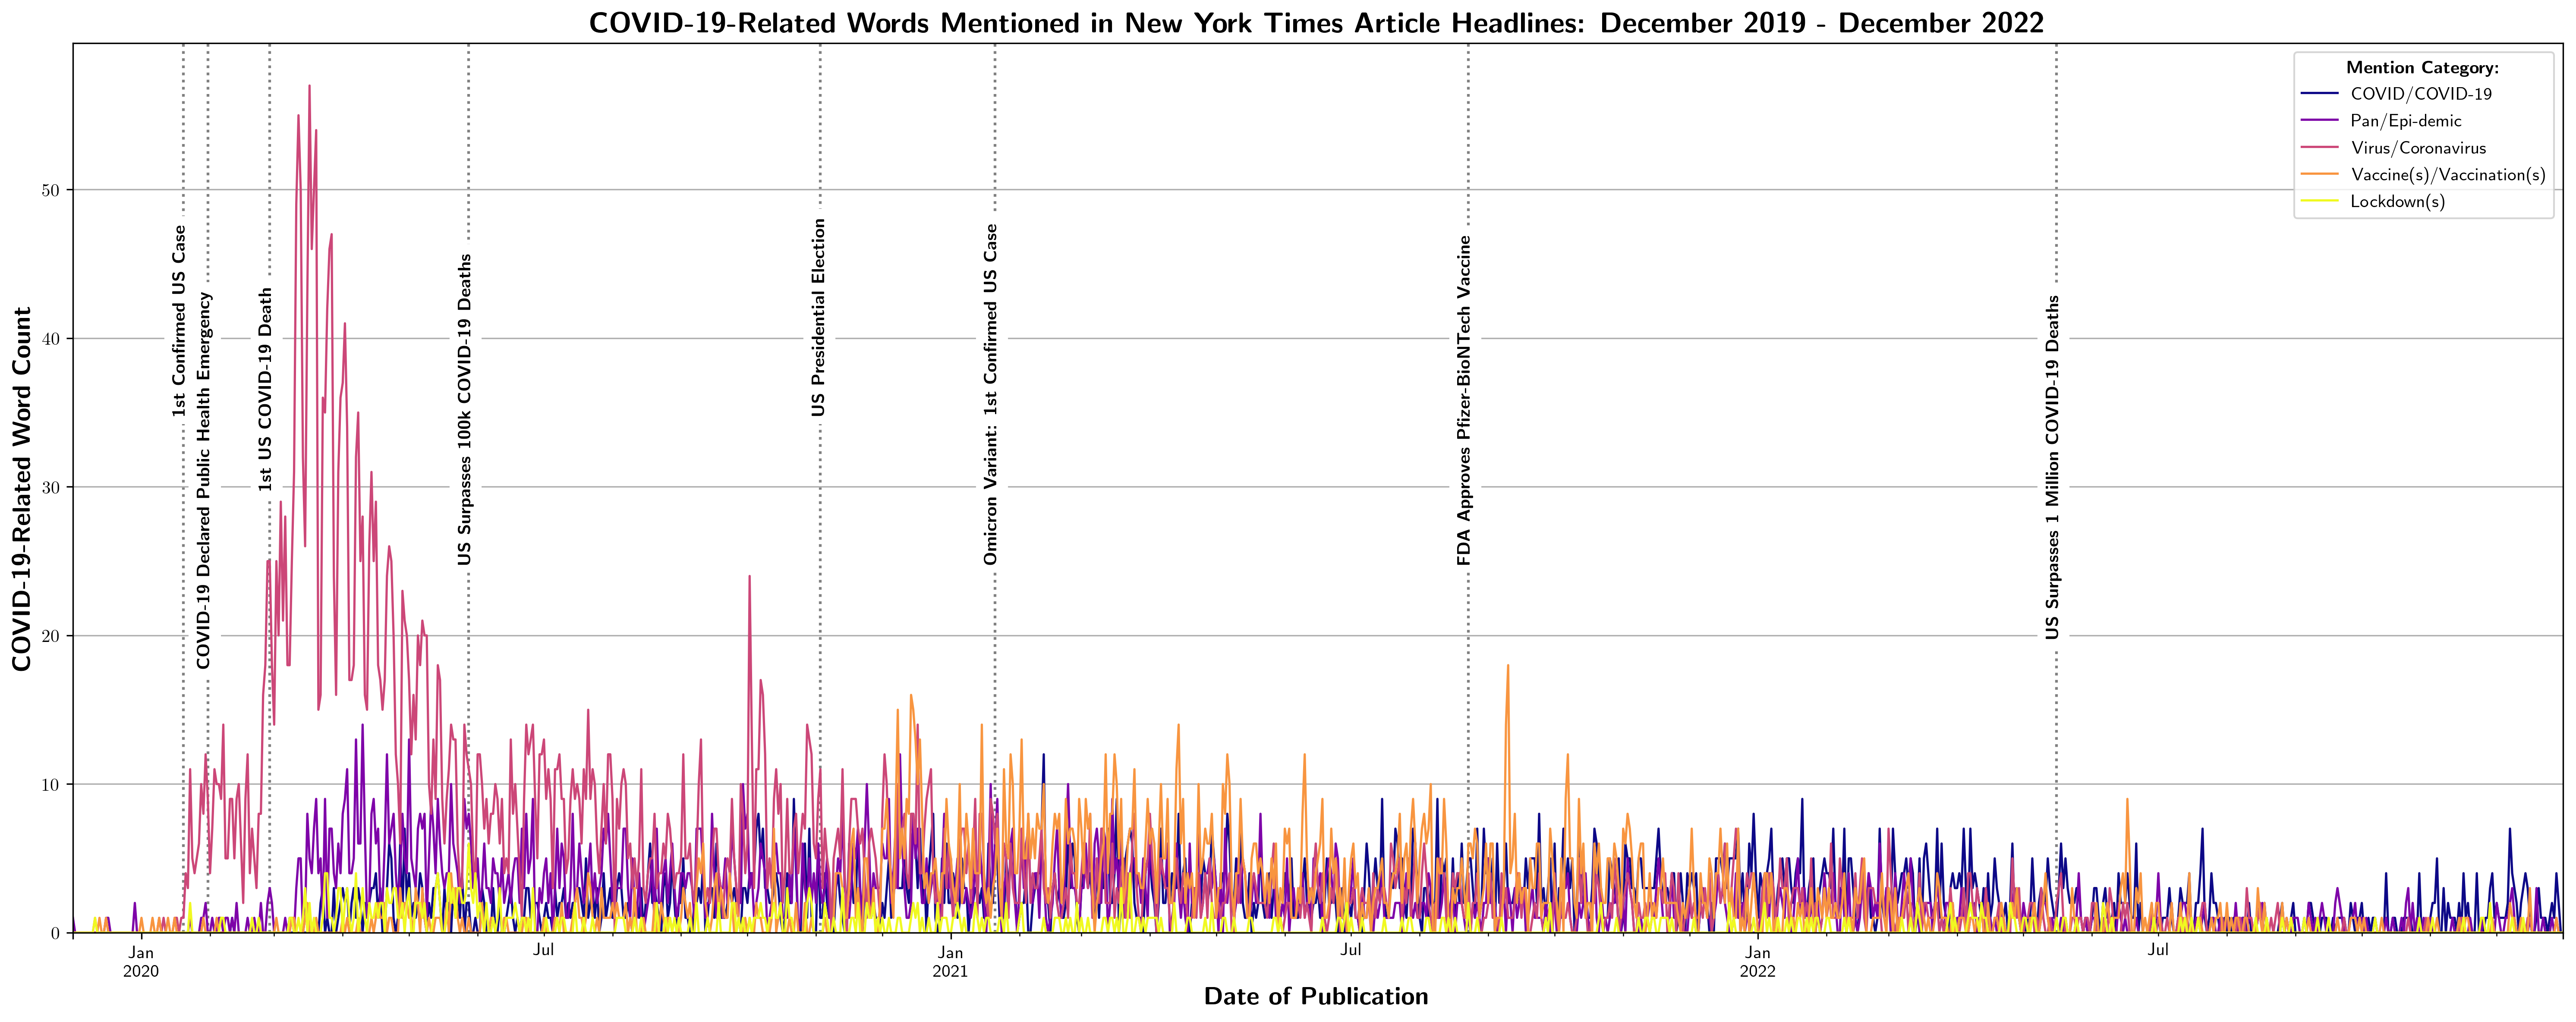

In [36]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rc
rc('text', usetex=True)

fig, ax = plt.subplots(figsize=(20,8))

daily_mentions[['covid_mentions', 'Xdemic_mentions', 'virus_mentions', 'vax_mentions', 'lockdown_mentions']].plot(ax=ax, lw=1.25, colormap='plasma')

ax.set_ylim(ymin=0)

tick_pos = [x for x in range(0, len(list(daily_mentions.index)))][::20]
tick_labs = [str(x)[:10] for x in list(daily_mentions.index)][::20]

ax.axvline(x=dt.date(2020, 1, 20), label='1st Confirmed US Case', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 1, 15), 35, r'\textbf{1st Confirmed US Case}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 2, 28), label='1st US COVID-19 Death', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 2, 23), 30, r'\textbf{1st US COVID-19 Death}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2021, 1, 21), label='Omicron Variant: 1st Confirmed US Case', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2021, 1, 16), 25, r'\textbf{Omicron Variant: 1st Confirmed US Case}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2021, 8, 23), label='FDA Approves Pfizer-BioNTech Vaccine', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2021, 8, 18), 25, r'\textbf{FDA Approves Pfizer-BioNTech Vaccine}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 5, 28), label='US Surpasses 100k COVID-19 Deaths', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 5, 23), 25, r'\textbf{US Surpasses 100k COVID-19 Deaths}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 1, 31), label='COVID-19 Declared Public Health Emergency', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 1, 26), 18, r'\textbf{COVID-19 Declared Public Health Emergency}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 11, 3), label='US Presidential Election', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 10, 30), 35, r'\textbf{US Presidential Election}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2022, 5, 16), label='US Surpasses 1 Million COVID-19 Deaths', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2022, 5, 11), 20, r'\textbf{US Surpasses 1 Million COVID-19 Deaths}', backgroundcolor='white', rotation=90, ha='left')



ax.legend(title=r"\textbf{Mention Category:}",
          labels=['COVID/COVID-19',
                'Pan/Epi-demic',
                'Virus/Coronavirus',
                'Vaccine(s)/Vaccination(s)',
                'Lockdown(s)'])

# ax.set_xticks(tick_pos)
# ax.set_xticklabels(tick_labs, rotation=45, ha='right')

ax.grid(axis='y')

ax.set_ylabel(r'\textbf{COVID-19-Related Word Count}', fontdict={'size':14})
ax.set_xlabel(r'\textbf{Date of Publication}', fontdict={'size':14})
ax.set_title(r'\textbf{COVID-19-Related Words Mentioned in New York Times Article Headlines: December 2019 - December 2022}', fontdict={'size':16})
plt.tight_layout();

Next, we will plot the total number of articles that mention covid related terms over the study period:

In [27]:
#Get the total number of articles pblished by day
articles_by_day = pd.DataFrame(data.publication_date.value_counts()).rename(columns={'publication_date': 'articles_published'})

#Join against a dataframe with all the dates (articles mentioning covid weren't published everyday)
daily_articles = pd.DataFrame(pd.date_range(dt.date(2019, 12, 1), dt.date(2022, 12, 31))).set_index(0).join(articles_by_day, how='outer')

#Fill the null values with 0
daily_articles.fillna(0, inplace=True)

#Show the daily mentions data
display(daily_articles)

,articles_published
2019-12-01,1.0
2019-12-02,0.0
2019-12-03,0.0
2019-12-04,0.0
2019-12-05,0.0
...,...
2022-12-27,1.0
2022-12-28,5.0
2022-12-29,2.0
2022-12-30,0.0


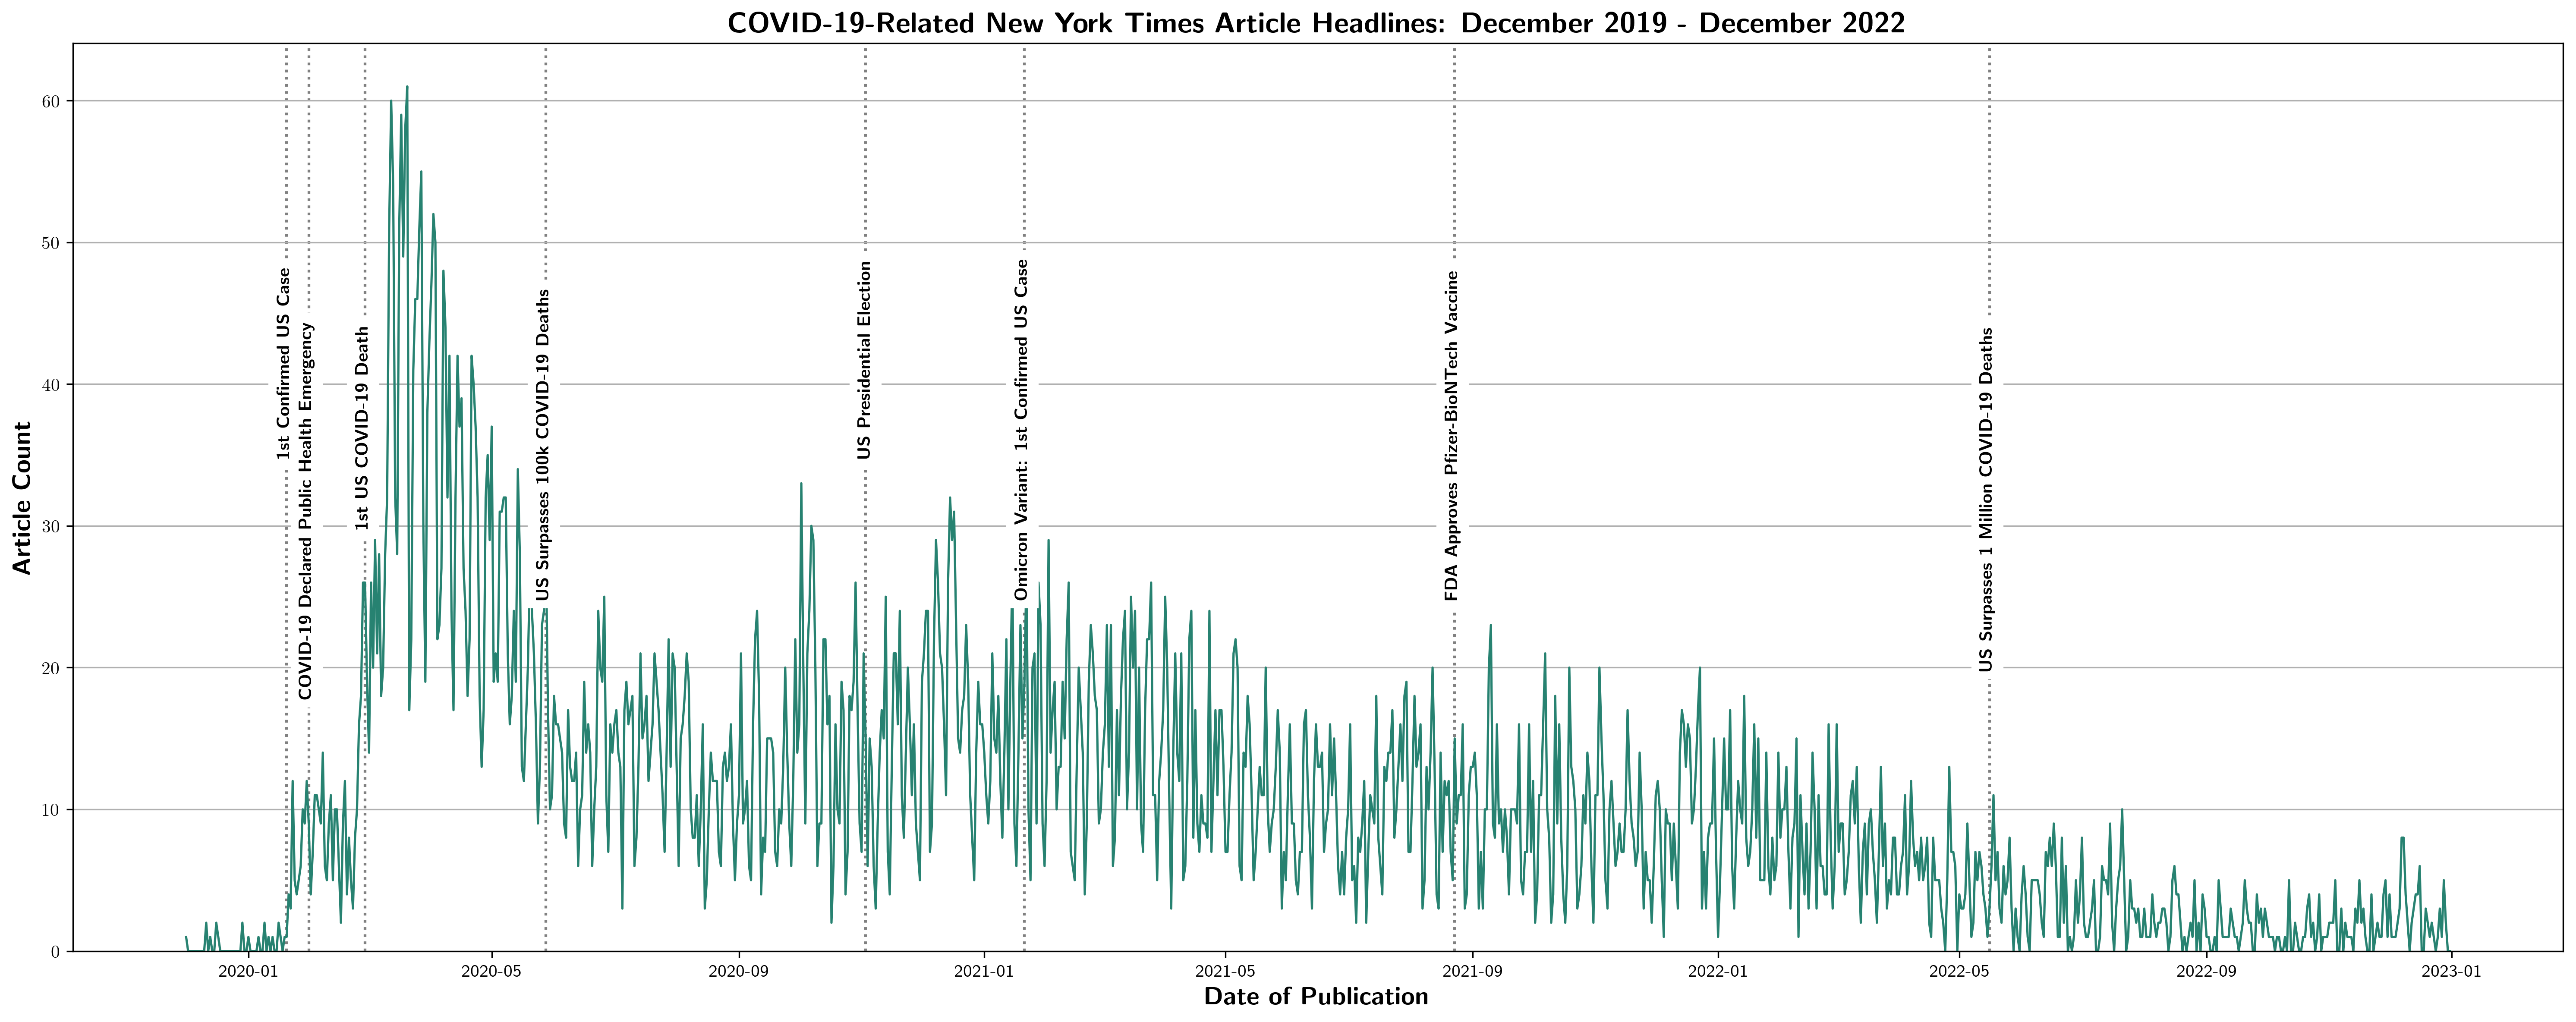

In [37]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
from matplotlib import rc
rc('text', usetex=True)

x = daily_articles.index
y = daily_articles.articles_published

fig, ax = plt.subplots(figsize=(20,8))

ax.plot(x, y, lw=1.25, color='#278271')

ax.set_ylim(ymin=0)

ax.axvline(x=dt.date(2020, 1, 20), label='1st Confirmed US Case', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 1, 15), 35, r'\textbf{1st Confirmed US Case}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 2, 28), label='1st US COVID-19 Death', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 2, 23), 30, r'\textbf{1st US COVID-19 Death}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2021, 1, 21), label='Omicron Variant: 1st Confirmed US Case', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2021, 1, 16), 25, r'\textbf{Omicron Variant: 1st Confirmed US Case}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2021, 8, 23), label='FDA Approves Pfizer-BioNTech Vaccine', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2021, 8, 18), 25, r'\textbf{FDA Approves Pfizer-BioNTech Vaccine}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 5, 28), label='US Surpasses 100k COVID-19 Deaths', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 5, 23), 25, r'\textbf{US Surpasses 100k COVID-19 Deaths}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 1, 31), label='COVID-19 Declared Public Health Emergency', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 1, 26), 18, r'\textbf{COVID-19 Declared Public Health Emergency}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2020, 11, 3), label='US Presidential Election', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2020, 10, 30), 35, r'\textbf{US Presidential Election}', backgroundcolor='white', rotation=90, ha='left')

ax.axvline(x=dt.date(2022, 5, 16), label='US Surpasses 1 Million COVID-19 Deaths', zorder=0, color='grey', linestyle=':')
ax.text(dt.date(2022, 5, 11), 20, r'\textbf{US Surpasses 1 Million COVID-19 Deaths}', backgroundcolor='white', rotation=90, ha='left')

ax.grid(axis='y')

ax.set_ylabel(r'\textbf{Article Count}', fontdict={'size':14})
ax.set_xlabel(r'\textbf{Date of Publication}', fontdict={'size':14})
ax.set_title(r'\textbf{COVID-19-Related New York Times Article Headlines: December 2019 - December 2022}', fontdict={'size':16})
plt.tight_layout();

## 4.3 So, what was the headlines?
One those days where there were and extremely high number of articles mentioning covid published, what were those headline? 

In [29]:
#See which days had the most articles punlished - 
articles_by_day.sort_values(by='articles_published', ascending=False).head(5)

,articles_published
2020-03-20,61
2020-03-12,60
2020-03-17,59
2020-03-19,58
2020-03-27,55


In [30]:
#Extract some headlines:
high_daily_cnt = list(articles_by_day.sort_values(by='articles_published', ascending=False).head(5).index)
headlines = " ".join(list(data.loc[data.publication_date.isin(high_daily_cnt)].main_headline))

Let's make a word cloud of those headlines:

2020-03-20 00:00:00


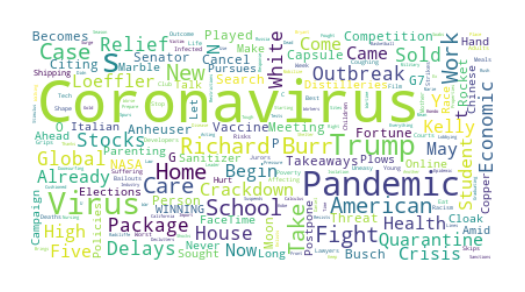

2020-03-12 00:00:00


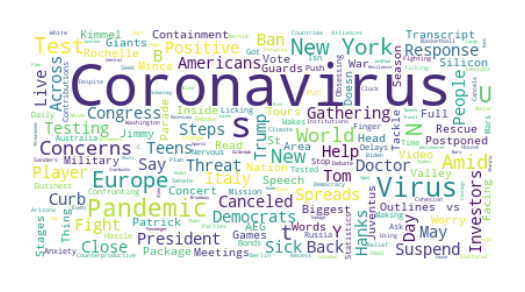

2020-03-17 00:00:00


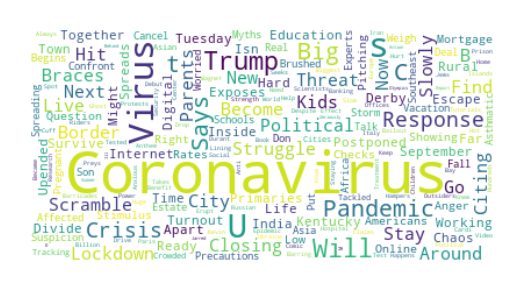

In [35]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

top_3_high_daily_cnt = list(articles_by_day.sort_values(by='articles_published', ascending=False).head(3).index)

for day in top_3_high_daily_cnt:

    headlines = " ".join(list(data.loc[data.publication_date==day].main_headline))

    df_wordcloud = WordCloud(background_color='white',max_font_size = 50).generate(headlines)
    mpl.rcParams['figure.dpi'] = 300
    fig, ax = plt.subplots(figsize=(2,3))
    ax.imshow(df_wordcloud, interpolation='bilinear')
    ax.axis("off")
    print(day)
    plt.show()


# _fin._